# Main Libraries

In [10]:
# quandl for financial data
import quandl
import pandas as pd
# Matplotlib
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline 

#rcParams style for plots
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Data from Quandl

In [30]:
quandl.ApiConfig.api_key = 'rFsSehe51RLzREtYhLfo'
#tesla data from quandl
tesla = quandl.get('WIKI/TSLA')
#GM data from quandl
gm = quandl.get('WIKI/GM')

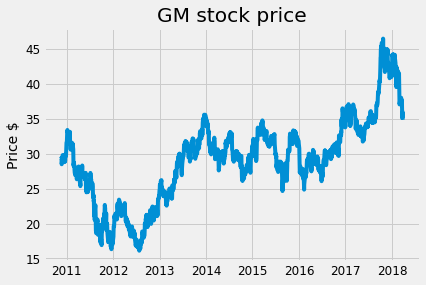

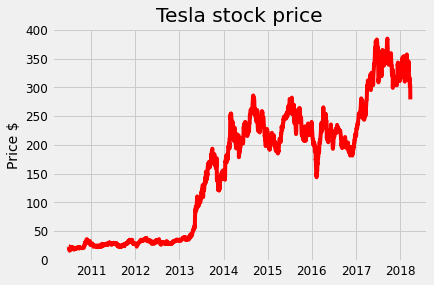

In [31]:
# Quick Visualization
#GM plot
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM stock price')
plt.ylabel('Price $');
plt.show()

#Tesla plot
plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla stock price')
plt.ylabel('Price $');
plt.show();


In [32]:
# Compute market capitalization, mutiply the average number of shares outstanding in each year times the share price
tesla_shares = {2018: 168e6, 2017:162e6, 2016:144e6, 2015:128e6, 2014:125e6, 2013:119e6, 2012:107e6, 2011:100e6, 2010:51e6}
gm_shares = {2018: 1.42e9, 2017:1.5e9, 2016:1.54e9, 2015:1.59e9, 2014:1.61e9, 2013:1.39e9, 2012:1.57e9, 2011:1.54e9, 2010:1.5e9}

In [36]:
# Calculate market capitalization creating a year column
tesla['Year'] = pd.DatetimeIndex(tesla.index).year
# Take dates frin index and remove date column
tesla.reset_index(level =0, inplace = True)
tesla['cap'] =0


In [44]:
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    
    # Update the cap column to shares times the price
    tesla.cap[i] = shares * tesla['Adj. Close'][i]

<ipython-input-44-afd3e02cc565>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla.cap[i] = shares * tesla['Adj. Close'][i]


In [47]:
# Calculate market capitalization creating a year column
gm['Year'] = pd.DatetimeIndex(gm.index).year
# Take dates frin index and remove date column
gm.reset_index(level =0, inplace = True)
gm['cap'] =0
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    
    # Update the cap column to shares times the price
    gm.cap[i] = shares * gm['Adj. Close'][i]

<ipython-input-47-67f09edb71eb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm.cap[i] = shares * gm['Adj. Close'][i]


In [53]:
# Merge the two datasets and rename the columns 
cars = gm.merge(tesla, on  = 'Date', how = 'inner')
cars.rename(columns = {'cap_x':'gm_cap', 'cap_y':'tesla_cap'}, inplace = True)

In [54]:
# Selecting only relevant columns 
cars = cars[['Date', 'gm_cap', 'tesla_cap']]
# Divide to get market cap into billion of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9

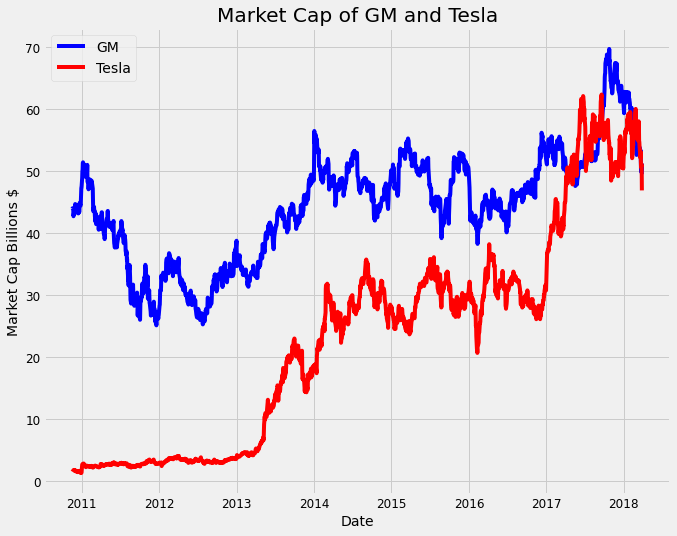

In [57]:
# Visual Comparison 
plt.figure(figsize = (10,8))
plt.plot(cars.Date, cars.gm_cap, 'b-', label = 'GM')
plt.plot(cars.Date, cars.tesla_cap, 'r-', label = 'Tesla')
plt.xlabel('Date'); plt.ylabel('Market Cap Billions $'); plt.title('Market Cap of GM and Tesla')
plt.legend();

In [59]:
import numpy as np 
#Find the first and last time Tesla was valuated higher than GM
first_date = np.min(list(cars[cars.tesla_cap > cars.gm_cap].Date))
last_date = np.max(list(cars[cars.tesla_cap > cars.gm_cap].Date))
print('Tesla was valuated higher than GM from {} to {}'.format(first_date, last_date))

Tesla was valuated higher than GM from 2017-04-10 00:00:00 to 2018-03-23 00:00:00


# Prophet models 

In [60]:
import prophet
#prophet requires columns ds (date) and y (value)
gm = gm.rename(columns = {'Date':'ds', 'cap':'y'})
#Put market cap in billions
gm['y'] = gm.y / 1e9

# Make prophet models and fit the data
# Changepoint_prior_scale can be changed to acvhieve a better fit 
gm_prophet = prophet.Prophet(changepoint_prior_scale = .05)
gm_prophet.fit(gm)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
# Repeat for Tesla 
tesla = tesla.rename(columns = {'Date':'ds', 'cap':'y'})
tesla.y = tesla.y / 1e9
tesla_prophet = prophet.Prophet(changepoint_prior_scale = .05)
tesla_prophet.fit(tesla)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Predictions for two years

In [63]:
# GM
gm_forecast = gm_prophet.make_future_dataframe(periods = 365 *2, freq = 'D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

# Tesla
tesla_forecast = tesla_prophet.make_future_dataframe(periods = 365 *2, freq = 'D')
tesla_forecast = tesla_prophet.predict(tesla_forecast)

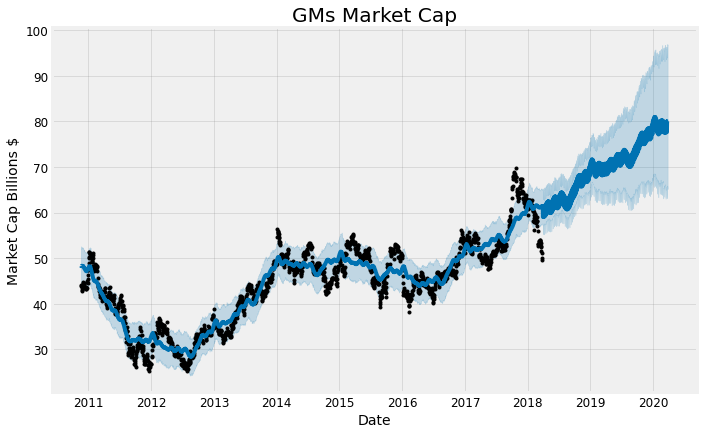

In [64]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap Billions $')
plt.title('GMs Market Cap');

Text(0.5, 1.0, 'Teslas Market Cap')

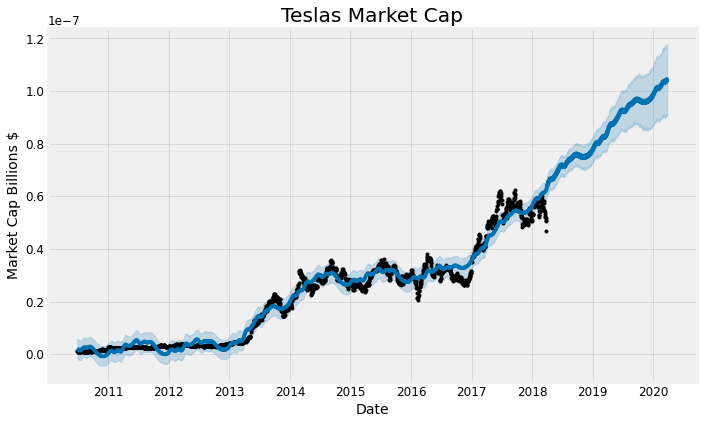

In [65]:
tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap Billions $')
plt.title('Teslas Market Cap')